# Import Libraries Needed

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px
import scipy.stats as stats
import sklearn

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.impute import KNNImputer,SimpleImputer
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import chi2

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics  import confusion_matrix ,accuracy_score,f1_score,classification_report,ConfusionMatrixDisplay

# Import Data

In [120]:
def wrangle(path, test_size=0.2, random_state=42):

    # 1. Load data
    df = pd.read_csv(path)

    # 2. Drop low-value columns ( imbalanced class)
    df.drop(columns=['prevalentStroke', 'diabetes', 'BPMeds'], inplace=True)


    # 3. Encode categorical data
    df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})
    df['Heart_ stroke'] = df['Heart_ stroke'].map({'No': 0, 'yes': 1})


    df['education'].fillna(df['education'].mode()[0], inplace= True)
    education_categories = [['uneducated', 'primaryschool', 'graduate', 'postgraduate']]
    encoder = OrdinalEncoder(categories=education_categories)
    df[['education']] = encoder.fit_transform(df[['education']])


    # 5. Split features & target
    X = df.drop(columns='Heart_ stroke')
    y = df['Heart_ stroke']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )


    # 6. Outlier handling (TRAIN ONLY)
    numeric_cols = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'BMI', 'glucose']

    z_scores = stats.zscore(X_train[numeric_cols])
    threshold = 2.5
    mask = ~(z_scores > threshold).any(axis=1)

    X_train = X_train.loc[mask]
    y_train = y_train.loc[mask]



    # 7. Imputation (fit on train)
    imputer = KNNImputer()
    X_train = pd.DataFrame(
        imputer.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )

    X_test = pd.DataFrame(
        imputer.transform(X_test),
        columns=X_test.columns,
        index=X_test.index
    )


    # 8. Feature Scaling
    scaler = StandardScaler()

    X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
    X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

    return X_train, X_test, y_train, y_test,df


In [121]:
X_train, X_test, y_train, y_test,df = wrangle('/content/heart_disease.csv')

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Gender         4238 non-null   int64  
 1   age            4238 non-null   int64  
 2   education      4238 non-null   float64
 3   currentSmoker  4238 non-null   int64  
 4   cigsPerDay     4209 non-null   float64
 5   prevalentHyp   4238 non-null   int64  
 6   totChol        4188 non-null   float64
 7   sysBP          4238 non-null   float64
 8   diaBP          4238 non-null   float64
 9   BMI            4219 non-null   float64
 10  heartRate      4237 non-null   float64
 11  glucose        3850 non-null   float64
 12  Heart_ stroke  4238 non-null   int64  
dtypes: float64(8), int64(5)
memory usage: 430.6 KB


In [124]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 848 entries, 1305 to 821
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Gender         848 non-null    float64
 1   age            848 non-null    float64
 2   education      848 non-null    float64
 3   currentSmoker  848 non-null    float64
 4   cigsPerDay     848 non-null    float64
 5   prevalentHyp   848 non-null    float64
 6   totChol        848 non-null    float64
 7   sysBP          848 non-null    float64
 8   diaBP          848 non-null    float64
 9   BMI            848 non-null    float64
 10  heartRate      848 non-null    float64
 11  glucose        848 non-null    float64
dtypes: float64(12)
memory usage: 86.1 KB


In [147]:
svm_model = SVC()
svm_model.fit(X_train, y_train)

SVC()

In [126]:
print(svm_model.score(X_train, y_train))
print(svm_model.score(X_test, y_test))

0.8556295399515739
0.847877358490566


In [128]:
svm_classification_report = sklearn.metrics.classification_report(y_test, svm_model.predict(X_test))
print(svm_classification_report)

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       719
           1       0.00      0.00      0.00       129

    accuracy                           0.85       848
   macro avg       0.42      0.50      0.46       848
weighted avg       0.72      0.85      0.78       848



In [ ]:
svm_model = SVC()

param_grid = {'C':[0.1,0.01,1,10],'kernel':['poly','rbf','sigmoid']}

grid_search = GridSearchCV(svm_model, param_grid, scoring = 'roc_auc')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .................................C=0.1, kernel=poly; total time=   0.2s
[CV] END .................................C=0.1, kernel=poly; total time=   0.2s
[CV] END .................................C=0.1, kernel=poly; total time=   0.2s
[CV] END .................................C=0.1, kernel=poly; total time=   0.2s
[CV] END .................................C=0.1, kernel=poly; total time=   0.1s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.1s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.1s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.1s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.1s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.1s
[CV] END ..............................C=0.1, kernel=sigmoid; total time=   0.2s
[CV] END ..............................C=0.1, ke

In [129]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
y_pred_test = dt.predict(X_test)
y_pred_train = dt.predict(X_train)
print(accuracy_score(y_train,y_pred_train))
print(accuracy_score(y_test,y_pred_test))

1.0
0.7429245283018868


In [130]:
dt_classification_report = sklearn.metrics.classification_report(y_test, dt.predict(X_test))
print(dt_classification_report)

              precision    recall  f1-score   support

           0       0.86      0.84      0.85       719
           1       0.20      0.22      0.21       129

    accuracy                           0.74       848
   macro avg       0.53      0.53      0.53       848
weighted avg       0.76      0.74      0.75       848



In [131]:
dt = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [20, 30,40,50,70, 100],


}

In [132]:
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid,scoring = 'roc_auc')
grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)
print("Best Training Score: ", grid_search.best_score_)

y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")

Best Parameters:  {'criterion': 'entropy', 'max_depth': 40}
Best Training Score:  0.553510966695249
Test Accuracy: 0.7382075471698113


In [134]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred_test = rf.predict(X_test)
y_pred_train = rf.predict(X_train)
print(accuracy_score(y_train,y_pred_train))
print(accuracy_score(y_test,y_pred_test))

0.9996973365617433
0.8419811320754716


In [137]:
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20],
    'criterion': ['gini', 'entropy']

}

In [139]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='roc_auc')
grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)
print("Best Training Score: ", grid_search.best_score_)

y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")

Best Parameters:  {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}
Best Training Score:  0.7026418747664996
Test Accuracy: 0.8455188679245284


In [140]:
xg = xgb.XGBClassifier()
xg.fit(X_train,y_train)
y_pred_test = xg.predict(X_test)
y_pred_train = xg.predict(X_train)
print(accuracy_score(y_train,y_pred_train))
print(accuracy_score(y_test,y_pred_test))

0.9954600484261501
0.8349056603773585


In [141]:
xg = xgb.XGBClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample' : [0.4, 0.6, 0.8, 1.0]

}

In [142]:
grid_search = GridSearchCV(estimator=xg, param_grid=param_grid,scoring='roc_auc')
grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)
print("Best Training Score: ", grid_search.best_score_)

y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")

Best Parameters:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.6}
Best Training Score:  0.7168262372565769
Test Accuracy: 0.847877358490566


In [151]:
svm_model = SVC(C = 10, kernel = 'rbf',probability=True)
dt_model  = DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=1, min_samples_split=5)
rf_model = RandomForestClassifier(criterion = 'gini', max_depth = 40, n_estimators = 150)
xg_model = xgb.XGBClassifier(learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8)



In [152]:
svm_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xg_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [153]:
acc_test_svm = svm_model.score(X_test, y_test)
acc_test_dt = dt_model.score(X_test, y_test)
acc_test_rf = rf_model.score(X_test, y_test)
acc_test_xg = xg_model.score(X_test, y_test)

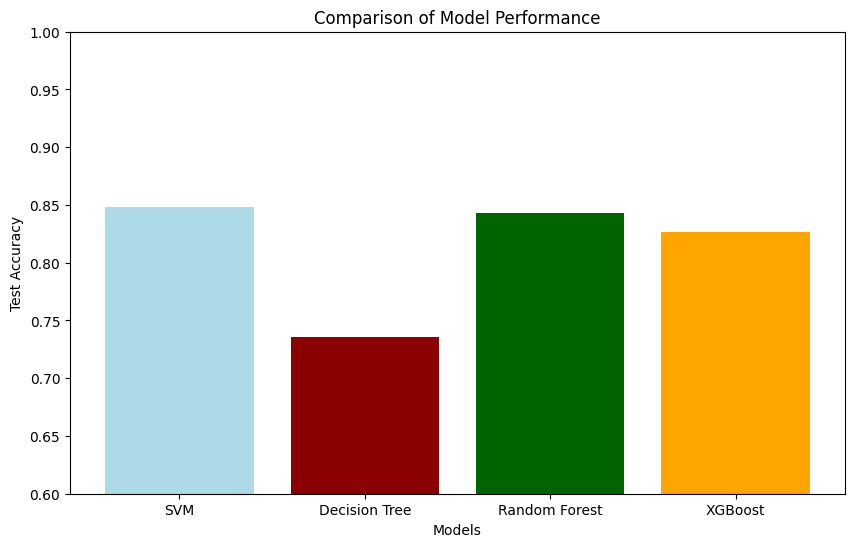

In [154]:
models = ['SVM','Decision Tree', 'Random Forest','XGBoost']
accuracies = [acc_test_svm, acc_test_dt, acc_test_rf, acc_test_xg]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['lightblue', 'darkred','darkgreen', 'orange', 'purple'])
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.title('Comparison of Model Performance')
plt.ylim([0.6, 1.0])
plt.show()


# ROC Curve

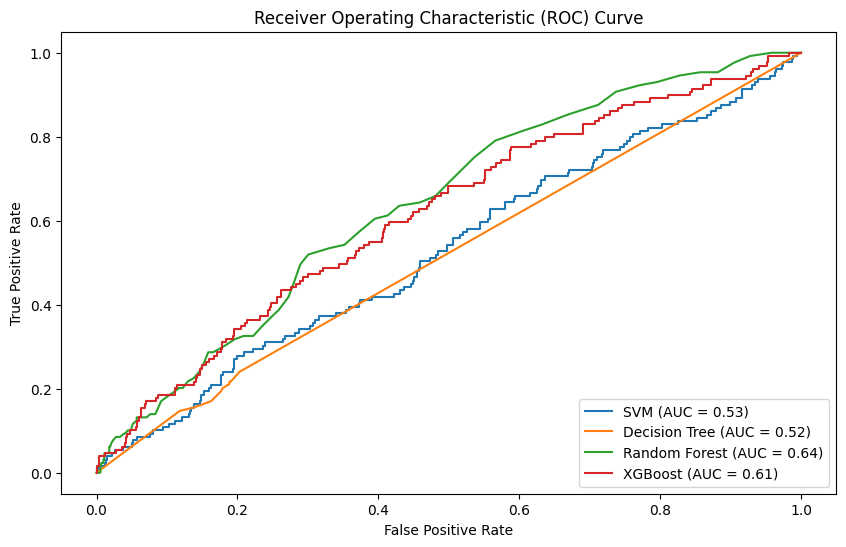

In [155]:
from sklearn.metrics import roc_curve, auc

models = [
    ('SVM',  svm_model.predict_proba(X_test)[:, 1]),
    ('Decision Tree', dt_model.predict_proba(X_test)[:, 1]),
    ('Random Forest', rf_model.predict_proba(X_test)[:, 1]),
    ('XGBoost', xg_model.predict_proba(X_test)[:, 1])
 ]

plt.figure(figsize=(10, 6))

for model_name, y_pred_proba in models:
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [157]:
import joblib

In [158]:
joblib.dump(rf_model, 'rf_model.pkl')

['rf_model.pkl']